In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

In [2]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])


In [3]:
train_dataset =torchds[:30700]  ##0.7*43823
test_dataset =torchds[30700:]
dl = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [4]:
class Cnn(nn.Module):

    def __init__(self, in_dim, n_class):

        super(Cnn, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_dim, 6, (1,2), stride=(1), padding=(0,1)),#6,1,9

            nn.ReLU(True),

            nn.MaxPool2d(1, 1),#6,1,9

            nn.Conv2d(6, 16, (1,3), stride=(1), padding=(0,1)),

            nn.ReLU(True), nn.MaxPool2d(1, 1))#16,1,9
   
            #5*144

        self.fc = nn.Linear(144, 16)
        
        self.fc1 = nn.Linear(16, 8)
        
        self.fc2 = nn.Linear(8, n_class)


    def forward(self, x):

        out = self.conv(x)

        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        out1=self.fc1(out)
        
        out=self.fc2(out1)
        
        #out = out.view(5)

        return out

In [5]:
model = Cnn(1, 1)
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [6]:
losslist=[]
for epoch in range(100):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0

    for i, data in enumerate(dl, 1):
        
            train_x=data[:,0:8]
            
            train_x=train_x.view(-1,1,1,8)
            
            train_y=data[:,8]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = model(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
           
                
    print('running_loss:-------')
    print(running_loss / (len(train_dataset)))            
    #print(out,train_y)

epoch 1
**********
running_loss:-------
0.00912652109864893
epoch 2
**********
running_loss:-------
0.008285053888129537
epoch 3
**********
running_loss:-------
0.008204407871667454
epoch 4
**********
running_loss:-------
0.008125710255596847
epoch 5
**********
running_loss:-------
0.008050675310516056
epoch 6
**********
running_loss:-------
0.007977427071391176
epoch 7
**********
running_loss:-------
0.007905051714349355
epoch 8
**********
running_loss:-------
0.007834796059621856
epoch 9
**********
running_loss:-------
0.007767054871944195
epoch 10
**********
running_loss:-------
0.007700933537867636
epoch 11
**********
running_loss:-------
0.007635308924079524
epoch 12
**********
running_loss:-------
0.0075674284733407175
epoch 13
**********
running_loss:-------
0.007497425944959981
epoch 14
**********
running_loss:-------
0.007425428558511095
epoch 15
**********
running_loss:-------
0.007351006538962114
epoch 16
**********
running_loss:-------
0.007273407037148453
epoch 17
********

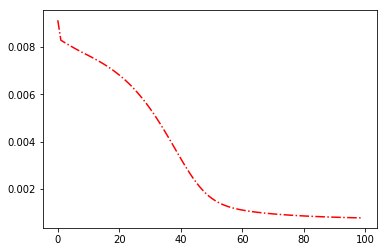

In [14]:
import matplotlib.pyplot as plt
plt.plot(losslist,'r-.') 
plt.show()

In [21]:
out.detach().numpy().shape

(13123, 1)

ValueError: x and y must have same first dimension, but have shapes (100,) and (13123, 1)

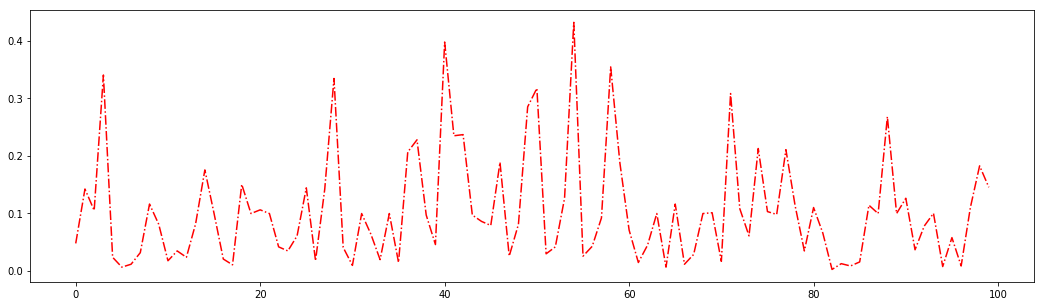

In [16]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [18]:
model.eval()
    
test_x=test_dataset[:,0:8]

test_x=test_x.view(-1,1,1,8)

test_y=test_dataset[:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

out = model(test_x)

loss = criterion(out, test_y)


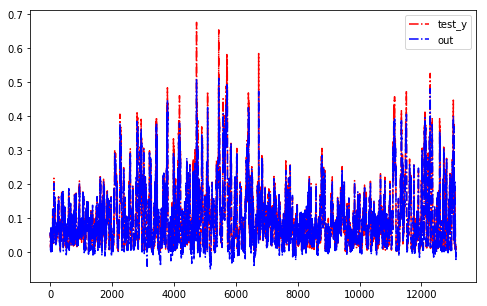

In [19]:
x=range(0,13123)
plt.figure(num=1,figsize=(8,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.numpy(),'r-.',label='test_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

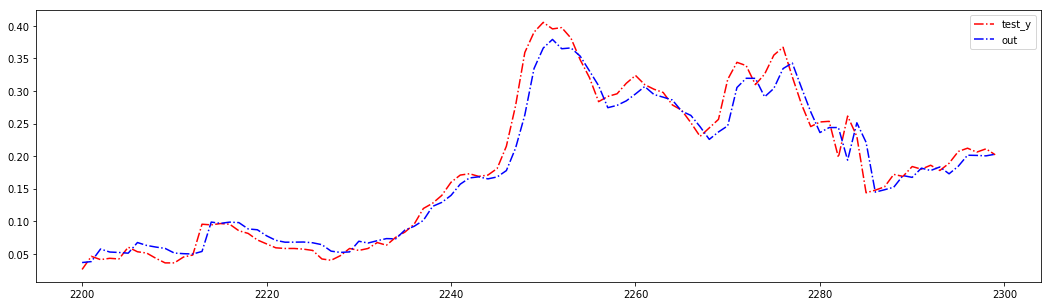

In [20]:
#x=range(0,13123)
x=range(2200,2300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.numpy()[2200:2300],'r-.',label='test_y') 
plt.plot(x,out.detach().numpy()[2200:2300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [22]:
# 保存模型
torch.save(model.state_dict(), './weathercnn-0.01-true-7.14.pth')